# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## 1.Business Understanding: Determine how a mail order company selling organic products can acquire new clients more efficiently

### Build a model to predict which individuals are most likely to become new customers for the company. Steps involved are as follows:

1. Investigate attributes/demographics of existing company clients. Understand which attributes are most meaninful for the business and use these as a basis for the model
2. Identify demographics of people in Germany most likely to be the new customers for the mail order company (use some sort of model to segment customers to determine best attributes for identifying how to Market to customers).
3. Predict individuals to target for mail order campaigns

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt #in terminal, first use pip to get latest....pip install scikit-plot


#from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## 2. Data Understanding

In [80]:
dias_attr = pd.read_excel('DIAS Attributes - Values 2017.xlsx', index_col=0)
dias_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', index_col=0)

In [4]:
#https://dev.to/chanduthedev/how-to-display-all-rows-from-data-frame-using-pandas-dha
#https://stackoverflow.com/questions/52580111/how-do-i-set-the-column-width-when-using-pandas-dataframe-to-html/52580495
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 90)
dias_info[['Attribute','Description']].sort_values(by='Attribute')

,Attribute,Description
NaN,AGER_TYP,best-ager typology
NaN,ALTERSKATEGORIE_GROB,age through prename analysis
NaN,ALTER_HH,main age within the household
NaN,ANREDE_KZ,gender
NaN,ANZ_HAUSHALTE_AKTIV,number of households known in this building
NaN,ANZ_HH_TITEL,number of holders of an academic title in the building
NaN,ANZ_PERSONEN,number of persons known in this household
NaN,ANZ_TITEL,number of bearers of an academic title within this household
NaN,ARBEIT,share of unemployed person in the community
NaN,BALLRAUM,distance to the next metropole


In [5]:
dias_attr.head(5)

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,NaN,NaN,0,no classification possible
NaN,NaN,NaN,1,passive elderly
NaN,NaN,NaN,2,cultural elderly
NaN,NaN,NaN,3,experience-driven elderly


In [6]:
#view unique values and counts of values per attribute. Seems there are 'unknowns', value = -1. will count these in each 
#data set after removing un-needed columns and decide what to do later
#https://stackoverflow.com/questions/26977076/pandas-unique-values-multiple-columns
dias_attr.groupby(['Value','Meaning']).size().reset_index().rename(columns={0:'count'}).sort_values(by='Meaning')

,Value,Meaning,count
18,1,01.01.1895 bis 31.12.1899,1
89,2,01.01.1900 bis 31.12.1904,1
158,3,01.01.1905 bis 31.12.1909,1
223,4,01.01.1910 bis 31.12.1914,1
280,5,01.01.1915 bis 31.12.1919,1
329,6,01.01.1920 bis 31.12.1924,1
363,7,01.01.1925 bis 31.12.1929,1
386,8,01.01.1930 bis 31.12.1934,1
404,9,01.01.1935 bis 31.12.1939,1
421,10,01.01.1940 bis 31.12.1944,1


In [44]:
#view unique values and counts of values per attribute. Seems there are 'unknowns', value = -1. will count these in each 
#column CAMEO_DEUG_2015 is string with numeric alpha. Seems important, has lifestyle, however, 
#another column CAMEO_DEU_2015 is similar with more detail. will drop CAMEO_DEUG_2015
#data set after removing un-needed columns and decide what to do later
#https://stackoverflow.com/questions/26977076/pandas-unique-values-multiple-columns
dias_attr.groupby(['Attribute','Value']).size().reset_index().rename(columns={0:'count'}).sort_values(by='Attribute')

,Attribute,Value,count
0,AGER_TYP,-1,1
1,ALTERSKATEGORIE_GROB,"-1, 0",1
2,ALTER_HH,0,1
3,ANREDE_KZ,"-1, 0",1
4,ANZ_HAUSHALTE_AKTIV,…,1
5,ANZ_HH_TITEL,…,1
6,ANZ_PERSONEN,…,1
7,ANZ_TITEL,…,1
8,BALLRAUM,-1,1
9,BIP_FLAG,-1,1


In [81]:
# load in the data, specify dtypes str to change all mixed types to string
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', dtype = 'str')
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';', dtype = 'str')

In [82]:
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype = 'str')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';', dtype = 'str')

In [47]:
#view top 5 records, all columns.
#as mentionened before, will remove 'CAMEO_DEU_2015'
#D19_LETZTER_KAUF_BRANCHE is text, EINGEFUEGT_AM is a date/time value, EINGEZOGENAM_HH_JAHR is year, 
#PRODUCT_GROUP and MULTI_BUYER are text, OST_WEST_KZ is alpha.

#CAMEO_DEU_2015: CAMEO_4.0: specific group>>>WILL REMOVE
#D19_LETZTER_KAUF_BRANCHE: not in excel metadata >>>>WILL REMOVE
#EINGEFUEGT_AM: not in original excel metadata>>>>>WILL REMOVE
#EINGEZOGENAM_HH_JAHR: not in original excel metadata>>>>>WILL REMOVE
#OST_WEST_KZ: lag indicating the former GDR/FRG >>>>WILL REMOVE, don't see this being high impact
#PRODUCT_GROUP and CUSTOMER_GROUP: This contains broad info about the customer. Will keep this, and convert text vals to num

pd.set_option('display.max_columns', None)
customers.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [55]:
#3 distinct values for product group, 2 for customer group. will replace 1st with 1,2,3, 2nd with 1 and 2
print(sorted(customers['PRODUCT_GROUP'].unique())), print(sorted(customers['CUSTOMER_GROUP'].unique()))

['COSMETIC', 'COSMETIC_AND_FOOD', 'FOOD']
['MULTI_BUYER', 'SINGLE_BUYER']


(None, None)

In [49]:
#view top 5 records, all columns.
#as mentionened before, will remove 'CAMEO_DEU_2015'
#D19_LETZTER_KAUF_BRANCHE is text, EINGEFUEGT_AM is a date/time value, EINGEZOGENAM_HH_JAHR is year, OST_WEST_KZ is alpha.

#CAMEO_DEU_2015: CAMEO_4.0: specific group>>>WILL REMOVE
#D19_LETZTER_KAUF_BRANCHE: not in excel metadata >>>>WILL REMOVE
#EINGEFUEGT_AM: not in original excel metadata>>>>>WILL REMOVE
#EINGEZOGENAM_HH_JAHR: not in original excel metadata>>>>>WILL REMOVE
#OST_WEST_KZ: lag indicating the former GDR/FRG >>>>WILL REMOVE, don't see this being high impact

azdias.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [4]:
#columns having -1 in azdias: ['AGER_TYP', 'HEALTH_TYP', 'SHOPPER_TYP', 'VERS_TYP']
#During data prep we will replace -1's(unknowns) with NaNs then impute with the mean
#https://stackoverflow.com/questions/50923707/get-column-name-which-contains-a-specific-value-at-any-rows-in-python-pandas
azdias.columns[azdias.isin(['-1']).any()]

Index(['AGER_TYP', 'HEALTH_TYP', 'SHOPPER_TYP', 'VERS_TYP'], dtype='object')

In [13]:
#columns having -1 in customers: ['AGER_TYP', 'HEALTH_TYP', 'SHOPPER_TYP', 'VERS_TYP']
customers.columns[customers.isin(['-1']).any()]

Index(['AGER_TYP', 'HEALTH_TYP', 'SHOPPER_TYP', 'VERS_TYP'], dtype='object')

In [8]:
#It appears columns in the .csv files that start with 'D19' do not end with 'RZ' as specified in the data dictionaries. 
#Example: D19_VOLLSORTIMENT_RZ is 'D19_VOLLSORTIMENT' in the .csv files. 
#https://stackoverflow.com/questions/21285380/find-column-whose-name-contains-a-specific-string
customers.filter(regex='D19').head(5)

,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,...,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST
0,0,0,10,0,0,0,10,10,0,0,...,0,0,0,10,10,10,0,0,0,0
1,0,1,6,0,5,0,10,10,0,6,...,0,0,0,10,10,10,0,0,6,0
2,0,0,10,0,0,0,10,10,0,0,...,0,0,0,10,10,10,0,0,0,0
3,0,0,10,0,0,0,10,10,0,0,...,0,0,0,9,10,10,0,6,6,0
4,1,2,3,5,0,3,10,7,0,0,...,3,0,0,10,10,10,0,0,0,0


In [9]:
customers.shape

(191652, 369)

In [10]:
customers.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1,10,NaN,NaN,NaN,NaN,10,1,...,2,6,9,7,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9,11,NaN,NaN,NaN,NaN,NaN,NaN,...,3,0,9,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1,6,NaN,NaN,NaN,NaN,0,1,...,11,6,9,2,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1,8,NaN,NaN,NaN,NaN,8,0,...,2,NaN,9,7,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1,20,NaN,NaN,NaN,NaN,14,7,...,4,2,9,3,1,FOOD,MULTI_BUYER,0,1,3


In [38]:
#unique LNR/persons...as count matches total rows in DF (1 row for each person)
customers.LNR.nunique()

191652

In [11]:
azdias.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9,0,NaN,NaN,NaN,NaN,21,11,...,4,8,11,10,3,9,4,5,2,1
2,910225,-1,9,17,NaN,NaN,NaN,NaN,17,10,...,2,9,9,6,3,9,2,5,2,3
3,910226,2,1,13,NaN,NaN,NaN,NaN,13,1,...,0,7,10,11,NaN,9,7,3,2,4
4,910241,-1,1,20,NaN,NaN,NaN,NaN,14,3,...,2,3,5,4,2,9,3,4,1,3


In [40]:
#unique LNR/persons...as count matches total rows in DF
azdias.LNR.nunique()

891221

In [12]:
azdias.shape, customers.shape

((891221, 366), (191652, 369))

In [5]:
#reset display options
#https://stackoverflow.com/questions/26246864/restoring-the-default-display-context-in-pandas
pd.reset_option('^display.', silent=True)

## 3. Data Preparation

In [15]:
#load in demographics sets
azdias2 = azdias.copy()

In [103]:
customers2 = customers.copy()

In [104]:
#first replace product and customer group customers data with numeric vals
customers2['PRODUCT_GROUP'].replace({'COSMETIC': 1, 'COSMETIC_AND_FOOD': 2, 'FOOD': 3}, inplace = True)
customers2['CUSTOMER_GROUP'].replace({'MULTI_BUYER': 1, 'SINGLE_BUYER': 2}, inplace = True)

In [7]:
#columns having -1 in azdias: ['AGER_TYP', 'HEALTH_TYP', 'SHOPPER_TYP', 'VERS_TYP']
#replace -1's(unknowns) with NaNs then impute with the mean
#https://stackoverflow.com/questions/29247712/how-to-replace-a-value-in-pandas-with-nan
azdias2['AGER_TYP'].replace({'-1': np.NaN}, inplace = True)
azdias2['HEALTH_TYP'].replace({'-1': np.NaN}, inplace = True)
azdias2['SHOPPER_TYP'].replace({'-1': np.NaN}, inplace = True)
azdias2['VERS_TYP'].replace({'-1': np.NaN}, inplace = True)
customers2['AGER_TYP'].replace({'-1': np.NaN}, inplace = True)
customers2['HEALTH_TYP'].replace({'-1': np.NaN}, inplace = True)
customers2['SHOPPER_TYP'].replace({'-1': np.NaN}, inplace = True)
customers2['VERS_TYP'].replace({'-1': np.NaN}, inplace = True)

In [20]:
#percent of nulls in each column, german population
#4 rows have > 90% nulls, 2 > 60%, some ~28%, many around 10%. 
#Want to keep most fields to retain value. The AGER_TYP field seems important though it holds 76% nulls
#will remove columns ALTER_KIND1-4 (>90% nulls), and keep remaining columns
pd.set_option('display.max_rows', None)
(np.sum(azdias2.isnull() == True)/azdias2.shape[0])*100

LNR                             0.000000
AGER_TYP                       76.019640
AKT_DAT_KL                      8.247000
ALTER_HH                        8.247000
ALTER_KIND1                    90.904837
ALTER_KIND2                    96.690047
ALTER_KIND3                    99.307691
ALTER_KIND4                    99.864792
ALTERSKATEGORIE_FEIN           29.504130
ANZ_HAUSHALTE_AKTIV            10.451729
ANZ_HH_TITEL                   10.884842
ANZ_KINDER                      8.247000
ANZ_PERSONEN                    8.247000
ANZ_STATISTISCHE_HAUSHALTE     10.451729
ANZ_TITEL                       8.247000
ARBEIT                         10.908181
BALLRAUM                       10.518154
CAMEO_DEU_2015                 11.106000
CAMEO_DEUG_2015                11.106000
CAMEO_INTL_2015                11.106000
CJT_GESAMTTYP                   0.544646
CJT_KATALOGNUTZER               0.544646
CJT_TYP_1                       0.544646
CJT_TYP_2                       0.544646
CJT_TYP_3       

In [24]:
#percent of nulls in each column, existing customer population
#similar to the German population 4 rows have > 90% nulls
#will remove columns ALTER_KIND1-4 (>90% nulls), and keep remaining columns
(np.sum(customers2.isnull() == True)/customers2.shape[0])*100

LNR                             0.000000
AGER_TYP                       48.059504
AKT_DAT_KL                     24.312817
ALTER_HH                       24.312817
ALTER_KIND1                    93.860748
ALTER_KIND2                    97.338927
ALTER_KIND3                    99.334732
ALTER_KIND4                    99.876860
ALTERSKATEGORIE_FEIN           27.050070
ANZ_HAUSHALTE_AKTIV            26.050863
ANZ_HH_TITEL                   27.189907
ANZ_KINDER                     24.312817
ANZ_PERSONEN                   24.312817
ANZ_STATISTISCHE_HAUSHALTE     26.050863
ANZ_TITEL                      24.312817
ARBEIT                         26.337320
BALLRAUM                       26.067560
CAMEO_DEU_2015                 26.312274
CAMEO_DEUG_2015                26.312274
CAMEO_INTL_2015                26.312274
CJT_GESAMTTYP                   1.676476
CJT_KATALOGNUTZER               1.676476
CJT_TYP_1                       1.676476
CJT_TYP_2                       1.676476
CJT_TYP_3       

In [17]:
#drop unwanted columns 
cols_drop = ['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM','EINGEZOGENAM_HH_JAHR','OST_WEST_KZ',
                  'ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4']
azdias2.drop(cols_drop, axis = 1, inplace = True)
customers2.drop(cols_drop, axis = 1, inplace = True)

In [108]:
#convert values to numeric, rogue/error values to nan with coerce 
#https://stackoverflow.com/questions/36814100/pandas-to-numeric-for-multiple-columns
cols2 = customers2.columns
customers2[cols2] = customers2[cols2].apply(pd.to_numeric, errors='coerce')

In [109]:
#impute nulls with mean
customers2.fillna(customers2.mean(), inplace = True)

In [10]:
#no nulls exist for cust pop
(np.sum(customers2.isnull() == True)/customers2.shape[0])*100

LNR                            0.0
AGER_TYP                       0.0
AKT_DAT_KL                     0.0
ALTER_HH                       0.0
ALTERSKATEGORIE_FEIN           0.0
ANZ_HAUSHALTE_AKTIV            0.0
ANZ_HH_TITEL                   0.0
ANZ_KINDER                     0.0
ANZ_PERSONEN                   0.0
ANZ_STATISTISCHE_HAUSHALTE     0.0
ANZ_TITEL                      0.0
ARBEIT                         0.0
BALLRAUM                       0.0
CAMEO_DEUG_2015                0.0
CAMEO_INTL_2015                0.0
CJT_GESAMTTYP                  0.0
CJT_KATALOGNUTZER              0.0
CJT_TYP_1                      0.0
CJT_TYP_2                      0.0
CJT_TYP_3                      0.0
CJT_TYP_4                      0.0
CJT_TYP_5                      0.0
CJT_TYP_6                      0.0
D19_BANKEN_ANZ_12              0.0
D19_BANKEN_ANZ_24              0.0
D19_BANKEN_DATUM               0.0
D19_BANKEN_DIREKT              0.0
D19_BANKEN_GROSS               0.0
D19_BANKEN_LOKAL    

In [18]:
#https://stackoverflow.com/questions/30673684/pandas-dataframe-first-x-columns
#split dataframes into iterations of 50 cols, from 357 cols, 7 new dfs
#concat later on axis 1 (azdias3 = pd.concat([az_1,az_2,az_3,az_4,az_5,az_6,az_7], axis = 1))
az_1 = azdias2.iloc[:, : 50].copy()
az_2 = azdias2.iloc[:, 50: 100].copy()
az_3 = azdias2.iloc[:, 100: 150].copy()
az_4 = azdias2.iloc[:, 150: 200].copy()
az_5 = azdias2.iloc[:, 200: 250].copy()
az_6 = azdias2.iloc[:, 250: 300].copy()
az_7 = azdias2.iloc[:, 300: 357].copy()

In [ ]:
#convert values to numeric, rogue/error values to nan with coerce############################

In [21]:
cols = az_1.columns
az_1[cols] = az_1[cols].apply(pd.to_numeric, errors='coerce')

In [27]:
cols = az_2.columns
az_2[cols] = az_2[cols].apply(pd.to_numeric, errors='coerce')

In [28]:
cols = az_3.columns
az_3[cols] = az_3[cols].apply(pd.to_numeric, errors='coerce')

In [29]:
cols = az_4.columns
az_4[cols] = az_4[cols].apply(pd.to_numeric, errors='coerce')

In [30]:
cols = az_5.columns
az_5[cols] = az_5[cols].apply(pd.to_numeric, errors='coerce')

In [31]:
cols = az_6.columns
az_6[cols] = az_6[cols].apply(pd.to_numeric, errors='coerce')

In [32]:
cols = az_7.columns
az_7[cols] = az_7[cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
#NOW IMPUTE WITH MEAN#######################################################################

In [34]:
az_1.fillna(az_1.mean(), inplace = True)

In [36]:
az_2.fillna(az_2.mean(), inplace = True)

In [37]:
az_3.fillna(az_3.mean(), inplace = True)

In [38]:
az_4.fillna(az_4.mean(), inplace = True)

In [39]:
az_5.fillna(az_5.mean(), inplace = True)

In [40]:
az_6.fillna(az_6.mean(), inplace = True)

In [41]:
az_7.fillna(az_7.mean(), inplace = True)

In [42]:
#combine 7 back to 1 df######################################################################
azdias3 = pd.concat([az_1,az_2,az_3,az_4,az_5,az_6,az_7],axis = 1, ignore_index=False)

In [43]:
azdias3.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,1.675376,4.421928,10.864126,13.700717,8.287263,0.040647,0.154018,1.727637,7.599356,...,2.417322,6.001214,7.53213,5.945972,3.933406,7.908791,4.052836,3,1,2
1,910220,1.675376,9.000000,0.000000,21.000000,11.000000,0.000000,0.000000,2.000000,12.000000,...,4.000000,8.000000,11.00000,10.000000,3.000000,9.000000,4.000000,5,2,1
2,910225,1.675376,9.000000,17.000000,17.000000,10.000000,0.000000,0.000000,1.000000,7.000000,...,2.000000,9.000000,9.00000,6.000000,3.000000,9.000000,2.000000,5,2,3
3,910226,2.000000,1.000000,13.000000,13.000000,1.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,7.000000,10.00000,11.000000,3.933406,9.000000,7.000000,3,2,4
4,910241,1.675376,1.000000,20.000000,14.000000,3.000000,0.000000,0.000000,4.000000,3.000000,...,2.000000,3.000000,5.00000,4.000000,2.000000,9.000000,3.000000,4,1,3


In [55]:
#validate no nulls exist in German gen pop df. confirmed...
(np.sum(azdias3.isnull() == True)/azdias3.shape[0])*100

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
6      0.0
7      0.0
8      0.0
9      0.0
10     0.0
11     0.0
12     0.0
13     0.0
14     0.0
15     0.0
16     0.0
17     0.0
18     0.0
19     0.0
20     0.0
21     0.0
22     0.0
23     0.0
24     0.0
25     0.0
26     0.0
27     0.0
28     0.0
29     0.0
30     0.0
31     0.0
32     0.0
33     0.0
34     0.0
35     0.0
36     0.0
37     0.0
38     0.0
39     0.0
40     0.0
41     0.0
42     0.0
43     0.0
44     0.0
45     0.0
46     0.0
47     0.0
48     0.0
49     0.0
50     0.0
51     0.0
52     0.0
53     0.0
54     0.0
55     0.0
56     0.0
57     0.0
58     0.0
59     0.0
60     0.0
61     0.0
62     0.0
63     0.0
64     0.0
65     0.0
66     0.0
67     0.0
68     0.0
69     0.0
70     0.0
71     0.0
72     0.0
73     0.0
74     0.0
75     0.0
76     0.0
77     0.0
78     0.0
79     0.0
80     0.0
81     0.0
82     0.0
83     0.0
84     0.0
85     0.0
86     0.0
87     0.0
88     0.0
89     0.0
90     0.0

In [95]:
azdias3.shape, customers2.shape

((891221, 357), (9500, 361))

In [98]:
#reduce each population to 30% for faster loading, final set, more manageable for modeling...
azdias4_f = azdias3.sample(frac =.3).copy()
customers3_F = customers2.sample(frac =.3).copy()

In [116]:
#export reduced azdias and customers for final
#current population sizes too big to work with
azdias4_f.to_csv('Udacity_AZDIAS_fin.csv', sep=';', index = False)  
customers3_F.to_csv('Udacity_cust_fin.csv', sep=';', index = False)  
pd.reset_option('^display.', silent=True)

## 4. Modeling

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [28]:
#did some browsing on how to reduce number of features in clustering to a 'feasible' number. Will use Elbow with k-means
#to understand the right number of features to use and reduce properly

#https://www.datacamp.com/community/tutorials/k-means-clustering-python
#https://www.datacamp.com/community/tutorials/k-means-clustering-r
#https://stats.stackexchange.com/questions/285323/what-should-be-the-optimum-number-of-features-for-10-million-observations-for-km
#https://realpython.com/k-means-clustering-python/
#https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/multivariate/how-to/cluster-k-means/interpret-the-results/key-results/
#https://towardsdatascience.com/the-easiest-way-to-interpret-clustering-result-8137e488a127
#https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1
#https://towardsdatascience.com/clustering-with-more-than-two-features-try-this-to-explain-your-findings-b053007d680a

In [73]:
### load in the final data having 30% of original records
azdias_mod = pd.read_csv('Udacity_AZDIAS_fin.csv', sep=';')
customers_mod = pd.read_csv('Udacity_cust_fin.csv', sep=';')

In [3]:
azdias_mod.shape, customers_mod.shape

((267366, 357), (57496, 360))

In [5]:
azdias_mod.head(3)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,877615,1.675376,1.0,0.0,13.700717,1.0,0.0,0.0,1.0,1.0,...,4.0,9.0,8.0,5.0,6.0,6.0,7.0,3,1,4
1,274557,2.000000,1.0,13.0,13.000000,1.0,0.0,0.0,3.0,1.0,...,0.0,2.0,3.0,4.0,0.0,4.0,8.0,2,2,3
2,231360,2.000000,1.0,9.0,9.000000,1.0,0.0,0.0,1.0,1.0,...,4.0,10.0,13.0,10.0,6.0,9.0,7.0,3,2,4


In [129]:
customers_mod.head(3)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,94847,1.588267,1.747525,11.352009,10.331579,4.965863,0.067413,0.136402,2.267828,4.701288,...,3.168868,4.152716,8.646371,3.723133,3,1,2,1,1,3
1,70807,1.588267,1.747525,11.352009,10.331579,4.965863,0.067413,0.136402,2.267828,4.701288,...,3.168868,4.152716,8.646371,3.723133,3,1,2,0,2,1
2,54851,1.588267,1.747525,11.352009,10.331579,4.965863,0.067413,0.136402,2.267828,4.701288,...,3.168868,4.152716,8.646371,3.723133,3,1,1,0,1,1


In [4]:
#remove customer identifier from existing customer features and Germany population data
customers_feat = customers_mod.drop(columns='LNR',axis=1)
pop_feat = azdias_mod.drop(columns='LNR',axis=1)

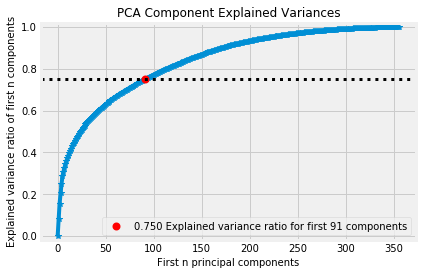

In [21]:
#https://scikit-plot.readthedocs.io/en/stable/decomposition.html
#https://towardsdatascience.com/principal-component-analysis-pca-with-scikit-learn-1e84a0c731b0
# target variance at 75%,
#scale data first
#looks like 91 components at 75%
#will reduce components to 91
X_pca = pop_feat.values
scaler = StandardScaler()
scaler.fit(X_pca)
X_pca_scaled = scaler.transform(X_pca)
pca = PCA(random_state=1)
pca.fit(X_pca_scaled)
skplt.decomposition.plot_pca_component_variance(pca,target_explained_variance=0.75)

plt.show()

In [25]:
#Reviewed the 'DIAS Attributes - Values 2017.xlsx' spreadsheet in the data understanding section, 
#going through each attribute and description, and keep 91 attributes that appear relevent/helpful to the mail order business
#Most of the 'KB' attributes are related to automobiles and not relevant to mail order. These also make up > 30% of the attributes.
#So no issues dropping most of them
cols_keep2 = ['ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ANREDE_KZ','BALLRAUM','ANZ_HH_TITEL','CAMEO_DEUG_2015',
              'CAMEO_INTL_2015','D19_BANKEN_DATUM','D19_BANKEN_OFFLINE_DATUM','D19_BIO_OEKO','D19_BILDUNG',
              'D19_ENERGIE','D19_GARTEN', 'D19_GESAMT_OFFLINE_DATUM','D19_GESAMT_ONLINE_DATUM','D19_KONSUMTYP',
             'D19_KOSMETIK','D19_LEBENSMITTEL','D19_NAHRUNGSERGAENZUNG','D19_TIERARTIKEL','D19_VERSAND_ANZ_12',
             'D19_VERSAND_DATUM','D19_VERSAND_OFFLINE_DATUM','D19_VERSAND_ONLINE_DATUM','D19_VOLLSORTIMENT','EWDICHTE',
              'FINANZTYP','EWDICHTE','FINANZ_MINIMALIST','FINANZ_SPARER','GEBAEUDETYP','GEBAEUDETYP_RASTER','GEBURTSJAHR', 
              'GREEN_AVANTGARDE','GFK_URLAUBERTYP', 'HEALTH_TYP','HH_EINKOMMEN_SCORE','INNENSTADT','KBA05_ALTER1',
              'KBA05_ALTER2','KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANTG1','KBA05_ANTG2','KBA05_ANTG3','KBA05_ANTG4', 
              'KBA05_BAUMAX','KBA05_AUTOQUOT', 'KBA05_FRAU', 'KKK', 'KONSUMNAEHE','LP_FAMILIE_FEIN','LP_LEBENSPHASE_FEIN', 
              'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'MIN_GEBAEUDEJAHR', 'MOBI_REGIO','NATIONALITAET_KZ', 
              'ONLINE_AFFINITAET', 'ORTSGR_KLS9','PLZ8_ANTG1', 'PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4', 'PLZ8_BAUMAX', 
              'PLZ8_GBZ', 'PLZ8_HHZ', 'PRAEGENDE_JUGENDJAHRE','REGIOTYP','RELAT_AB','SEMIO_DOM','SEMIO_ERL','SEMIO_FAM',
              'SEMIO_KAEM','SEMIO_KRIT','SEMIO_KULT','SEMIO_LUST','SEMIO_MAT', 'SEMIO_PFLICHT','SEMIO_RAT','SEMIO_REL',
              'SEMIO_SOZ','SEMIO_TRADV','SEMIO_VERT','SHOPPER_TYP','SOHO_KZ','RETOURTYP_BK_S','TITEL_KZ','WOHNDAUER_2008',
              'WOHNLAGE']

len(cols_keep2)

customers_feat2 = customers_feat[cols_keep2].copy()
pop_feat2 = pop_feat[cols_keep2].copy()
customers_feat2.shape, pop_feat2.shape

((57496, 91), (267366, 91))

In [26]:
#initiate K means, fit existing customers df, iterate up to K clusters. 
#For K I randomly chose 15 to provide a good spread for the elbow graphs
#identify where 'elbow' occurs, IE, SSE lowers and starts really tapering off, this is the point of best trade off, 
#indicating best number of 'k' values to use with K means model
#https://realpython.com/k-means-clustering-python/

new_c = customers_feat2.values
scaler = StandardScaler()
scaler.fit(new_c)
new_c_scaled2 = scaler.transform(new_c)

kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42,}

# A list holds the SSE values for each k value
sse = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(new_c_scaled2)
    sse.append(kmeans.inertia_)

In [30]:
#initiate K means, fit German population df, iterate up to K clusters. 
#For K I randomly chose 15 to provide a good spread for the elbow graphs
#identify where 'elbow' occurs, IE, SSE lowers and starts really tapering off, this is the point of best trade off, 
#indicating best number of 'k' values to use with K means model
#https://realpython.com/k-means-clustering-python/

new_g = pop_feat2.values
scaler = StandardScaler()
scaler.fit(new_g)
new_g_scaled2 = scaler.transform(X_pca_c)


kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42,}

# A list holds the SSE values for each k value
sse_pop = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    #kmeans.fit(pop_feat)
    kmeans.fit(new_g_scaled2)
    sse_pop.append(kmeans.inertia_)

In [27]:
np.savetxt('sse.csv', sse, delimiter=',')

In [31]:
np.savetxt('sse_pop.csv', sse_pop, delimiter=',')

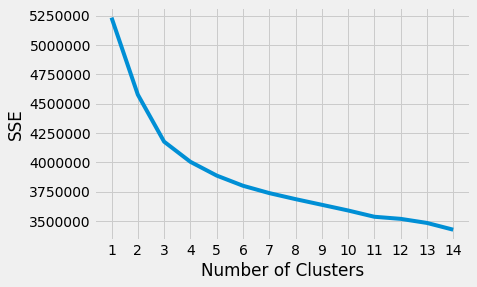

In [32]:
#plot SSE Elbow: results show SSE has a very leveled tapering off after ~6 clusters ....this will be optimal
#https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib
#https://www.kite.com/python/answers/how-to-set-the-width-and-height-of-a-figure-in-matplotlib-in-python
#rcParams['figure.figsize'] = 5, 10
#width1 = 10
#height1 = 5
#width_height_1 = (width1, height1)
#plt.figure(figsize=width_height_1)
plt.style.use("fivethirtyeight")
plt.plot(range(1, 15), sse)
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

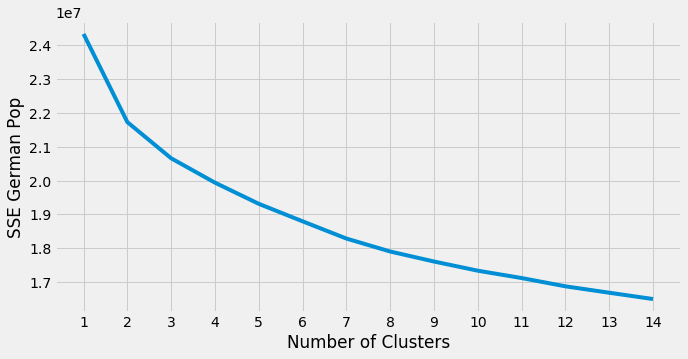

In [33]:
# plot SSE Elbow: results show SSE really tapers off after 6-7 clusters ....this will be optimal
#https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib
#https://www.kite.com/python/answers/how-to-set-the-width-and-height-of-a-figure-in-matplotlib-in-python
#rcParams['figure.figsize'] = 5, 10
width1 = 10
height1 = 5
width_height_1 = (width1, height1)
plt.figure(figsize=width_height_1)
plt.style.use("fivethirtyeight")
plt.plot(range(1, 15), sse_pop)
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE German Pop")
plt.show()

In [34]:
def km_pipe(X, clusters=6):
    '''function to:
    - pipeline using standardscaler to scale features, use pca for dimensionality reduction, and use kmeans for clustering 
    - fit pipeline with training data
    - predict on test data
    '''
    kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42, "n_clusters":clusters}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ("pca", PCA(n_components=2, random_state=42)),
        ('km', KMeans(**kmeans_kwargs))
    ])
    
    
    # fit training data and transform (fit+transform for standardscaler), then use km classifier
    pipeline.fit_transform(X, y=None)
    # predict on test data
    y_pred = pipeline.predict(X)
    
    return pipeline, y_pred

In [35]:
pipeline_cust, y_pred_cust = km_pipe(customers_feat2)
pipeline_gen_pop, y_pred_gen_pop = km_pipe(pop_feat2)

In [36]:
#combine german population df with kmeans cluster
azdias_mod["cluster_German_pop"] = y_pred_gen_pop

In [37]:
#https://stats.stackexchange.com/questions/213171/testing-whether-two-datasets-cluster-similarly
#https://www.researchgate.net/post/How-to-measure-the-similarity-between-two-cluster-results
#convert array to pandas series, normalize to give frequencies
y_pred_gen_pop_ser = pd.Series(y_pred_gen_pop)
y_pred_gen_pop_ser.value_counts(normalize=True)

4    0.255373
3    0.192388
2    0.144203
5    0.138611
1    0.138544
0    0.130881
dtype: float64

In [38]:
#combine customer population df with kmeans cluster
customers_mod["cluster_existing_custs"] = y_pred_cust

In [79]:
#convert array to pandas series, normalize to give frequencies
y_pred_cust_ser = pd.Series(y_pred_cust)
y_pred_cust_ser.value_counts(normalize=True)

1    0.258947
0    0.181684
4    0.155421
3    0.153421
2    0.128211
5    0.122316
dtype: float64

In [39]:
#create 'percent of total' metrics using cluster labeled customer and German population data 
#show percent of total for each cluster, will compare customer and German population sets side by side

germ_pop_cluster_ct = azdias_mod.groupby(["cluster_German_pop"],as_index=False).agg({"LNR" : "count"})
germ_pop_cluster_ct.rename(columns={'LNR': 'total_german', 'cluster_German_pop': 'Cluster'}, inplace=True)

germ_pop_cluster_pct = germ_pop_cluster_ct
germ_pop_cluster_pct['total_german'] = germ_pop_cluster_pct['total_german']/germ_pop_cluster_pct['total_german'].sum()
germ_pop_cluster_pct.rename(columns={'total_german': 'perc_tot_german'}, inplace=True)

cust_cluster_ct = customers_mod.groupby(["cluster_existing_custs"],as_index=False).agg({"LNR" : "count"})
cust_cluster_ct.rename(columns={'LNR': 'total_exist_custs', 'cluster_existing_custs': 'Cluster'}, inplace=True)

cust_cluster_pct = cust_cluster_ct
cust_cluster_pct['total_exist_custs'] = cust_cluster_pct['total_exist_custs']/cust_cluster_ct['total_exist_custs'].sum()
cust_cluster_pct.rename(columns={'total_exist_custs': 'perc_tot_exist_custs'}, inplace=True)

In [40]:
#clusters 0,1,2,5 show a greater proportion of existing customers clustered together than the German population

#This indicates customers within these clusters contain attributes/features that best represent the customer base for the 
#mail order company.

#next we will look at the features for customers within these clusters
cluster_perc_diffs = pd.merge(germ_pop_cluster_pct, cust_cluster_pct, on="Cluster")
cluster_perc_diffs

,Cluster,perc_tot_german,perc_tot_exist_custs
0,0,0.130881,0.131331
1,1,0.138544,0.248000
2,2,0.144203,0.185317
3,3,0.192388,0.149889
4,4,0.255373,0.109695
5,5,0.138611,0.175769


(<matplotlib.axes._subplots.AxesSubplot at 0x7f09287b2208>, (57496, 361))

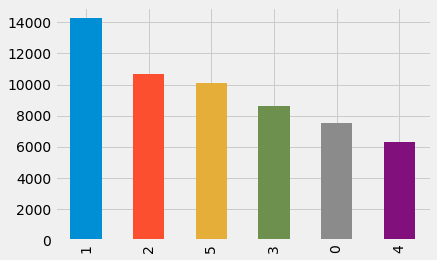

In [41]:
#plot count of total features from customer group
#cluster 1 has a higher proportion of customers than other clusters
customers_mod.cluster_existing_custs.value_counts().plot.bar(),customers_mod.shape

In [44]:
#compute mean of each feature initially kept. 
#these are the targeted feature values of the German population most likely to become a customer!!
avg_cluster = customers_mod.groupby(by='cluster_existing_custs').mean()
avg_cluster.reset_index(inplace=True)
avg_cluster[cols_keep2]

,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,BALLRAUM,ANZ_HH_TITEL,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BIO_OEKO,...,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,RETOURTYP_BK_S,TITEL_KZ,WOHNDAUER_2008,WOHNLAGE
0,3.481790,9.505761,1.460734,3.877500,0.055668,5.368599,35.809869,9.539266,9.952986,0.405509,...,2.985035,4.010197,2.777248,4.824791,1.722982,0.011124,4.161399,0.025824,8.411601,3.043736
1,1.715829,11.243321,1.524020,4.317428,0.066499,4.360519,29.427781,9.997054,9.999719,0.004068,...,6.942422,2.015990,3.021320,1.039975,1.670523,0.009684,3.126989,0.021199,8.630267,3.729767
2,3.391741,9.976631,1.389207,5.068565,0.021174,3.423648,23.800173,9.583013,9.975692,0.361333,...,3.260347,4.050868,3.087095,4.968278,1.533874,0.008822,3.713860,0.015298,8.673768,4.402593
3,3.637155,12.523323,1.181365,3.737731,0.040566,4.073773,28.439032,8.761778,9.708517,1.025760,...,3.149919,4.551404,2.718380,5.857043,1.766892,0.008239,3.969364,0.033650,8.788582,2.801218
4,3.465039,9.704297,1.506580,2.790075,0.260875,7.130837,45.044279,9.432852,9.946250,0.479626,...,2.877121,4.332963,2.706992,4.477248,1.887201,0.009672,4.280193,0.020929,8.343111,3.147138
5,3.557491,14.507124,1.155254,5.189353,0.016118,2.956791,20.851323,8.614190,9.587671,1.225510,...,3.451217,4.639917,3.017613,5.804572,1.563372,0.012468,3.654964,0.015733,8.893034,4.681251


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [2]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype = 'str')

In [48]:
#see how many response/successful customer onboarding instances occured from mailout train set
#small customer onboarding rate
mailout_train.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [49]:
mailout_train.shape

(42962, 367)

In [50]:
mailout_train.head(3)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1,8,NaN,NaN,NaN,NaN,8,15,...,5,2,1,6,9,3,3,0,2,4
1,1771,1,4,13,NaN,NaN,NaN,NaN,13,1,...,1,2,1,4,9,7,1,0,2,3
2,1776,1,1,9,NaN,NaN,NaN,NaN,7,0,...,6,4,2,NaN,9,2,3,0,1,4


In [51]:
mailout_train.LNR.nunique()

42962

In [3]:
mailout_train2 = mailout_train.copy()

In [4]:
#replace -1 with NANs to not lose value, will impute with mean later
#https://stackoverflow.com/questions/29247712/how-to-replace-a-value-in-pandas-with-nan
mailout_train2.replace('-1', np.NaN, inplace = True)

In [5]:
#convert all column values from string to numeric
#https://stackoverflow.com/questions/36814100/pandas-to-numeric-for-multiple-columns
pd.options.mode.chained_assignment = None  # default='warn'
cols = mailout_train2.columns
mailout_train2[cols] = mailout_train2[cols].apply(pd.to_numeric, errors='coerce')

In [6]:
#impute nulls with mean
mailout_train2.fillna(mailout_train2.mean(), inplace = True)

In [56]:
#some nulls still exist, look at these columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 90)
(np.sum(mailout_train2.isnull() == True)/mailout_train2.shape[0])*100

LNR                              0.0
AGER_TYP                         0.0
AKT_DAT_KL                       0.0
ALTER_HH                         0.0
ALTER_KIND1                      0.0
ALTER_KIND2                      0.0
ALTER_KIND3                      0.0
ALTER_KIND4                      0.0
ALTERSKATEGORIE_FEIN             0.0
ANZ_HAUSHALTE_AKTIV              0.0
ANZ_HH_TITEL                     0.0
ANZ_KINDER                       0.0
ANZ_PERSONEN                     0.0
ANZ_STATISTISCHE_HAUSHALTE       0.0
ANZ_TITEL                        0.0
ARBEIT                           0.0
BALLRAUM                         0.0
CAMEO_DEU_2015                 100.0
CAMEO_DEUG_2015                  0.0
CAMEO_INTL_2015                  0.0
CJT_GESAMTTYP                    0.0
CJT_KATALOGNUTZER                0.0
CJT_TYP_1                        0.0
CJT_TYP_2                        0.0
CJT_TYP_3                        0.0
CJT_TYP_4                        0.0
CJT_TYP_5                        0.0
C

In [57]:
# going back to the original metadata spreadsheets imported in earlier:
#appears 2 columns not found, 2 have definitions listed below
#I don't believe removing these 4 columns will have a large impact, so these columns will be 
#removed

#CAMEO_DEU_2015: CAMEO_4.0: specific group
#fOST_WEST_KZ: lag indicating the former GDR/FRG
#D19_LETZTER_KAUF_BRANCHE: not in excel metadata
#EINGEFUEGT_AM: not in original excel metadata
pd.reset_option('^display.', silent=True)
mailout_train[['EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE','CAMEO_DEU_2015','OST_WEST_KZ']].tail(10)

,EINGEFUEGT_AM,D19_LETZTER_KAUF_BRANCHE,CAMEO_DEU_2015,OST_WEST_KZ
42952,1992-02-10 00:00:00,D19_DIGIT_SERV,6B,W
42953,1996-11-09 00:00:00,D19_VERSICHERUNGEN,2C,W
42954,NaN,NaN,NaN,NaN
42955,1992-02-10 00:00:00,D19_BEKLEIDUNG_GEH,3D,O
42956,1992-02-12 00:00:00,D19_SONSTIGE,8A,W
42957,1992-02-10 00:00:00,D19_HAUS_DEKO,3C,W
42958,1992-02-10 00:00:00,D19_HAUS_DEKO,6B,O
42959,1992-02-10 00:00:00,D19_BUCH_CD,4A,W
42960,1992-02-12 00:00:00,D19_BUCH_CD,8A,W
42961,1992-02-10 00:00:00,D19_UNBEKANNT,4A,W


In [7]:
#columns to drop
cols_drop = ['EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE','CAMEO_DEU_2015','OST_WEST_KZ']
mailout_train3 = mailout_train2.copy()
mailout_train3.drop(cols_drop, axis = 1, inplace = True)

In [8]:
#ML Pipeline. KNN  after reviewing scikit cheat sheet:
#https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
def knn(X_train, X_test, y_train, y_test):
    '''function to:
    - pipeline scale with standard scaler, classify with knn
    - fit pipeline with training data
    - predict on test data
    '''
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors = 5))
    ])
    
    # fit/train transformers and classifier
    pipeline.fit(X_train, y_train)
    # predict on test data
    y_pred = pipeline.predict(X_test)
    
    pipeline_knn = pipeline
    y_pred_knn = y_pred
    
    return pipeline_knn, y_pred_knn

In [9]:
#Response column indicates customers successfully onboarded. Remove that column for x, input set
#y value set as response for each column, as response is output 
X= mailout_train3.drop(columns=['LNR', 'RESPONSE'],axis=1).values
y = mailout_train3.RESPONSE.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [10]:
#train pipeline 2
pipeline_knn, y_pred_knn = knn(X_train, X_test, y_train, y_test)

In [14]:
#show parameters used knn
pipeline_knn.get_params()

{'memory': None,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('clf',
   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
              metric_params=None, n_jobs=1, n_neighbors=5, p=2,
              weights='uniform'))],
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'clf': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=5, p=2,
            weights='uniform'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'clf__algorithm': 'auto',
 'clf__leaf_size': 30,
 'clf__metric': 'minkowski',
 'clf__metric_params': None,
 'clf__n_jobs': 1,
 'clf__n_neighbors': 5,
 'clf__p': 2,
 'clf__weights': 'uniform'}

In [54]:
#accuracy and roc score
accuracy_score(y_test,y_pred_knn), roc_auc_score(y_test, y_pred_knn)

(0.98750872837303127, 0.5)

In [59]:
#parameters for gridsearch + model fitting; then print best parameters from analysis
#https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657
#new params: {'clf__metric': 'euclidean', 'clf__n_neighbors': 5, 'clf__weights': 'uniform'} 0.987663352509
#looks like all that changed was metric 'minkowski' to 'euclidean'
parameters = {                             
          

        'clf__n_neighbors' : [3,5,11,19],     
        'clf__weights' : ['uniform','distance'],
        'clf__metric' : ['euclidean','manhattan']
}

cv = GridSearchCV(pipeline_knn, param_grid=parameters, verbose=3)

cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)

print(cv.best_params_, cv.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] clf__metric=euclidean, clf__n_neighbors=3, clf__weights=uniform .
[CV]  clf__metric=euclidean, clf__n_neighbors=3, clf__weights=uniform, score=0.9858354114713217, total= 2.1min
[CV] clf__metric=euclidean, clf__n_neighbors=3, clf__weights=uniform .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min remaining:    0.0s


[CV]  clf__metric=euclidean, clf__n_neighbors=3, clf__weights=uniform, score=0.9870324189526185, total= 2.1min
[CV] clf__metric=euclidean, clf__n_neighbors=3, clf__weights=uniform .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.2min remaining:    0.0s


[CV]  clf__metric=euclidean, clf__n_neighbors=3, clf__weights=uniform, score=0.9864312082210915, total= 2.1min
[CV] clf__metric=euclidean, clf__n_neighbors=3, clf__weights=distance 
[CV]  clf__metric=euclidean, clf__n_neighbors=3, clf__weights=distance, score=0.9858354114713217, total= 2.1min
[CV] clf__metric=euclidean, clf__n_neighbors=3, clf__weights=distance 
[CV]  clf__metric=euclidean, clf__n_neighbors=3, clf__weights=distance, score=0.9870324189526185, total= 2.0min
[CV] clf__metric=euclidean, clf__n_neighbors=3, clf__weights=distance 
[CV]  clf__metric=euclidean, clf__n_neighbors=3, clf__weights=distance, score=0.9864312082210915, total= 2.1min
[CV] clf__metric=euclidean, clf__n_neighbors=5, clf__weights=uniform .
[CV]  clf__metric=euclidean, clf__n_neighbors=5, clf__weights=uniform, score=0.9876309226932668, total= 2.1min
[CV] clf__metric=euclidean, clf__n_neighbors=5, clf__weights=uniform .
[CV]  clf__metric=euclidean, clf__n_neighbors=5, clf__weights=uniform, score=0.98763092

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 294.9min finished


{'clf__metric': 'euclidean', 'clf__n_neighbors': 5, 'clf__weights': 'uniform'} 0.987663352509


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [15]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype = 'str')

In [116]:
#see how many response/successful customer onboarding instances occured from mailout train set
#small customer onboarding rate
mailout_test.head(3)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1,7,NaN,NaN,NaN,NaN,6,2,...,4,5,6,3,6,9,3,3,1,4
1,1770,-1,1,0,NaN,NaN,NaN,NaN,0,20,...,1,5,2,1,6,9,5,3,1,4
2,1465,2,9,16,NaN,NaN,NaN,NaN,11,2,...,3,9,6,3,2,9,4,3,2,4


In [117]:
mailout_test.shape

(42833, 366)

In [16]:
mailout_test.LNR.nunique()

42833

In [16]:
mailout_test2 = mailout_test.copy()

In [17]:
#replace -1 with NANs to not lose value, will impute with mean later
#https://stackoverflow.com/questions/29247712/how-to-replace-a-value-in-pandas-with-nan
mailout_test2.replace('-1', np.NaN, inplace = True)

In [18]:
#convert all column values from string to numeric
#https://stackoverflow.com/questions/36814100/pandas-to-numeric-for-multiple-columns
pd.options.mode.chained_assignment = None  # default='warn'
cols = mailout_test2.columns
mailout_test2[cols] = mailout_test2[cols].apply(pd.to_numeric, errors='coerce')

In [19]:
#impute nulls with mean
mailout_test2.fillna(mailout_test2.mean(), inplace = True)

In [124]:
#some nulls still exist, look at these columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 90)
(np.sum(mailout_test2.isnull() == True)/mailout_test2.shape[0])*100

LNR                              0.0
AGER_TYP                         0.0
AKT_DAT_KL                       0.0
ALTER_HH                         0.0
ALTER_KIND1                      0.0
ALTER_KIND2                      0.0
ALTER_KIND3                      0.0
ALTER_KIND4                      0.0
ALTERSKATEGORIE_FEIN             0.0
ANZ_HAUSHALTE_AKTIV              0.0
ANZ_HH_TITEL                     0.0
ANZ_KINDER                       0.0
ANZ_PERSONEN                     0.0
ANZ_STATISTISCHE_HAUSHALTE       0.0
ANZ_TITEL                        0.0
ARBEIT                           0.0
BALLRAUM                         0.0
CAMEO_DEU_2015                 100.0
CAMEO_DEUG_2015                  0.0
CAMEO_INTL_2015                  0.0
CJT_GESAMTTYP                    0.0
CJT_KATALOGNUTZER                0.0
CJT_TYP_1                        0.0
CJT_TYP_2                        0.0
CJT_TYP_3                        0.0
CJT_TYP_4                        0.0
CJT_TYP_5                        0.0
C

In [20]:
#columns to drop
cols_drop = ['EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE','CAMEO_DEU_2015','OST_WEST_KZ']
mailout_test3 = mailout_test2.copy()
mailout_test3.drop(cols_drop, axis = 1, inplace = True)

In [21]:
#df with only LNR/Account to join back later to identify LNR/Acct after prediction
LNR_test = mailout_test.LNR

In [22]:
#predict on mailout_test cleansed data (IE, mailout_test becomes input testing X, IE- X_test). 
#original 'seen' data, X_train, y_train is prior train set..fit model with this, predict on X_test
X_test_new= mailout_test3.drop(columns=['LNR'],axis=1).values

In [23]:
#updated ML Pipeline. KNN  after reviewing scikit cheat sheet:
##optimal params: {'clf__metric': 'euclidean', 'clf__n_neighbors': 5, 'clf__weights': 'uniform'} 0.987663352509
def knn_new(X_train, X_test, y_train, y_test):
    '''function to:
    - pipeline scale with standard scaler, classify with knn
    - fit pipeline with training data
    - predict on test data
    '''
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean', weights = 'uniform'))
    ])
    
    # fit/train transformers and classifier
    pipeline.fit(X_train, y_train)
    # predict on test data
    y_pred = pipeline.predict(X_test)
    
    pipeline_knn = pipeline
    y_pred_knn = y_pred
    
    return pipeline_knn, y_pred_knn

In [24]:
pipeline_knn, y_pred_knn = knn_new(X_train, X_test_new, y_train, y_test)

In [25]:
#https://www.geeksforgeeks.org/create-a-dataframe-from-a-numpy-array-and-specify-the-index-column-and-column-headers/
array = y_pred_knn
index_values = LNR_test
# creating a list of column names
column_values = ['RESPONSE']
# creating the dataframe
df_pred_fin = pd.DataFrame(data = array, index = index_values, columns = column_values)

In [26]:
#change index to column
df_pred_fin.reset_index(level=0, inplace=True)
df_pred_fin.head()

,LNR,RESPONSE
0,1754,0
1,1770,0
2,1465,0
3,1470,0
4,1478,0


In [27]:
df_pred_fin.RESPONSE.value_counts()

0    42830
1        3
Name: RESPONSE, dtype: int64

In [28]:
df_pred_fin.to_csv('df_final_pred_kaggle.csv', sep=';', index = False)  